In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir -p /content/data/photos
!mkdir -p /content/data/buildings
!mkdir -p /content/data/manuscripts


In [3]:
!unzip -q /content/drive/MyDrive/heritage_restoration_data/photos_dataset.zip     -d /content/data/photos/
!unzip -q /content/drive/MyDrive/heritage_restoration_data/buildings_dataset.zip   -d /content/data/buildings/
!unzip -q /content/drive/MyDrive/heritage_restoration_data/manuscripts_dataset.zip -d /content/data/manuscripts/


In [4]:
!ls /content/data/photos
!ls /content/data/buildings
!ls /content/data/manuscripts



edges  raw
edges  raw
edges  images  masks


## Imports + Path Setup

In [5]:
!pip install -q diffusers transformers accelerate safetensors controlnet-aux opencv-python pillow tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 22.8 MB/s eta 0:00:00


In [6]:
import os
import glob
from PIL import Image
import torch
from tqdm.auto import tqdm

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

Using: cuda


In [8]:
PHOTOS_RAW      = "/content/data/photos/raw"
PHOTOS_EDGES    = "/content/data/photos/edges"

In [9]:
BUILDINGS_RAW   = "/content/data/buildings/raw"
BUILDINGS_EDGES = "/content/data/buildings/edges"

In [11]:
MANUSCRIPTS_RAW   = "/content/data/manuscripts/images"
MANUSCRIPTS_EDGES = "/content/data/manuscripts/edges"

In [12]:
OUT_PHOTOS      = "/content/results_stage2/photos"
OUT_BUILDINGS   = "/content/results_stage2/buildings"
OUT_MANUSCRIPTS   = "/content/results_stage2/manuscripts"

In [13]:
os.makedirs(OUT_PHOTOS, exist_ok=True)
os.makedirs(OUT_BUILDINGS, exist_ok=True)
os.makedirs(OUT_MANUSCRIPTS, exist_ok=True)

##Load Stable Diffusion + ControlNet

In [14]:
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline, UniPCMultistepScheduler


In [15]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [16]:
pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [18]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

print("Pipeline ready.")

Pipeline ready.


## Restoration function

In [68]:
def restore_batch(
    raw_dir, edge_dir, out_dir,
    strength, guidance, steps,
    prompt, negative
):
    os.makedirs(out_dir, exist_ok=True)

    images = sorted(glob.glob(f"{raw_dir}/*"))
    edges = {os.path.basename(e): e for e in glob.glob(f"{edge_dir}/*")}

    for img_path in tqdm(images):
        fname = os.path.basename(img_path)

        # CORRECT MAPPING RULE
        edge_name = (
            fname.replace(".jpg", "_edges.png")
                 .replace(".jpeg", "_edges.png")
        )

        if edge_name not in edges:
            print("Missing edge for:", fname, "| expected:", edge_name)
            continue

        base = Image.open(img_path).convert("RGB").resize((512,512))
        cond = Image.open(edges[edge_name]).convert("RGB").resize((512,512))

        out = pipe(
            prompt=prompt,
            negative_prompt=negative,
            image=base,
            control_image=cond,
            strength=strength,
            guidance_scale=guidance,
            num_inference_steps=steps
        ).images[0]

        out.save(os.path.join(out_dir, fname))


## Processing the dataset

In [69]:
restore_batch(
    PHOTOS_RAW, PHOTOS_EDGES, OUT_PHOTOS,
    strength=0.30,
    guidance=7.0,
    steps=20,
    prompt="high-quality restoration, realistic, sharp, detailed, clean",
    negative="blur, extra edges, distortions, artifacts, deformed structure"
)

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [51]:
!rm -rf /content/data/buildings/raw_small
!rm -rf /content/data/buildings/edges_small

!mkdir /content/data/buildings/raw_small
!mkdir /content/data/buildings/edges_small


In [52]:
import glob, os, shutil, random

RAW_DIR = "/content/data/buildings/raw"
EDGE_DIR = "/content/data/buildings/edges"

raw_files = sorted(glob.glob(f"{RAW_DIR}/*.jpg"))
edge_files = sorted(glob.glob(f"{EDGE_DIR}/*.png"))

edge_names = [os.path.basename(e) for e in edge_files]

matched_pairs = []

for raw in raw_files:
    fname = os.path.basename(raw)
    edge_name = fname.replace(".jpg", "_edges.png")
    if edge_name in edge_names:
        matched_pairs.append((raw, os.path.join(EDGE_DIR, edge_name)))

print("Total matched building images:", len(matched_pairs))


Total matched building images: 408


In [53]:
chosen_25 = random.sample(matched_pairs, 25)

RAW_SMALL = "/content/data/buildings/raw_small"
EDGE_SMALL = "/content/data/buildings/edges_small"

for raw_path, edge_path in chosen_25:
    shutil.copy(raw_path, RAW_SMALL)
    shutil.copy(edge_path, EDGE_SMALL)

print("Copied 25 matched images.")


Copied 25 matched images.


In [54]:
print("Raw small:", len(os.listdir(RAW_SMALL)))
print("Edge small:", len(os.listdir(EDGE_SMALL)))


Raw small: 25
Edge small: 25


In [55]:
restore_batch(
    RAW_SMALL,
    EDGE_SMALL,
    OUT_BUILDINGS,
    strength=0.35,
    guidance=6.5,
    steps=20,
    prompt="building restoration, realistic texture, clean sharp edges, detailed structure",
    negative="distorted lines, warped architecture, melted surfaces"
)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [71]:
def restore_batch(
    raw_dir, edge_dir, out_dir,
    strength, guidance, steps,
    prompt, negative,
    mode="auto"
):
    os.makedirs(out_dir, exist_ok=True)

    raw_files = sorted(glob.glob(f"{raw_dir}/*"))
    edge_files = sorted(glob.glob(f"{edge_dir}/*"))
    edge_names = {os.path.basename(e): e for e in edge_files}

    for img_path in tqdm(raw_files):
        fname = os.path.basename(img_path)

        if mode == "building":
            edge_name = (
                fname.replace(".jpg", "_edges.png")
                     .replace(".jpeg", "_edges.png")
            )

        elif mode == "photo":
            edge_name = (
                fname.replace(".jpg", "_edges.png")
                     .replace(".jpeg", "_edges.png")
            )

        elif mode == "manuscript":
            edge_name = fname.replace(".png", "_edges.png")

        else:
            edge_name = (
                fname.replace(".jpg", "_edges.png")
                     .replace(".jpeg", "_edges.png")
                     .replace(".png", "_edges.png")
            )

        if edge_name not in edge_names:
            print("Missing edge for:", fname, "| expected:", edge_name)
            continue

        base = Image.open(img_path).convert("RGB").resize((512, 512))
        cond = Image.open(edge_names[edge_name]).convert("RGB").resize((512, 512))

        out = pipe(
            prompt=prompt,
            negative_prompt=negative,
            image=base,
            control_image=cond,
            strength=strength,
            guidance_scale=guidance,
            num_inference_steps=steps,
        ).images[0]

        out.save(os.path.join(out_dir, fname))

    print("DONE:", out_dir)


In [74]:
!rm -rf /content/data/manuscripts/images_small
!rm -rf /content/data/manuscripts/edges_small

!mkdir -p /content/data/manuscripts/images_small
!mkdir -p /content/data/manuscripts/edges_small


In [75]:
import glob, os, shutil, random

RAW_M = "/content/data/manuscripts/images"
EDGE_M = "/content/data/manuscripts/edges"

raw_files = sorted(glob.glob(f"{RAW_M}/*.png"))
edge_files = sorted(glob.glob(f"{EDGE_M}/*.png"))

edge_names = [os.path.basename(e) for e in edge_files]

matched = []

for raw in raw_files:
    fname = os.path.basename(raw)
    edge_name = fname.replace(".png", "_edges.png")
    if edge_name in edge_names:
        matched.append((raw, os.path.join(EDGE_M, edge_name)))

print("Total matched manuscript images:", len(matched))

# Random 30
chosen = random.sample(matched, 30)

for raw_path, edge_path in chosen:
    shutil.copy(raw_path, "/content/data/manuscripts/images_small")
    shutil.copy(edge_path, "/content/data/manuscripts/edges_small")

print("Copied 30 manuscripts.")


Total matched manuscript images: 152
Copied 30 manuscripts.


In [90]:
restore_batch(
    "/content/data/manuscripts/images_small",
    "/content/data/manuscripts/edges_small", OUT_MANUSCRIPTS,
    strength=0.40,
    guidance=7.5,
    steps=20,
    prompt="ancient manuscript restoration, clean text, enhanced ink, no damage",
    negative="ink bleeding, distortion, over-smoothing",
    mode="manuscript"
)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/8 [00:00<?, ?it/s]

DONE: /content/results_stage2/manuscripts


In [91]:
!zip -qr /content/results_stage2.zip /content/results_stage2
!cp /content/results_stage2.zip /content/drive/MyDrive/heritage_restoration_data/


##comparison images (Before vs After grid)

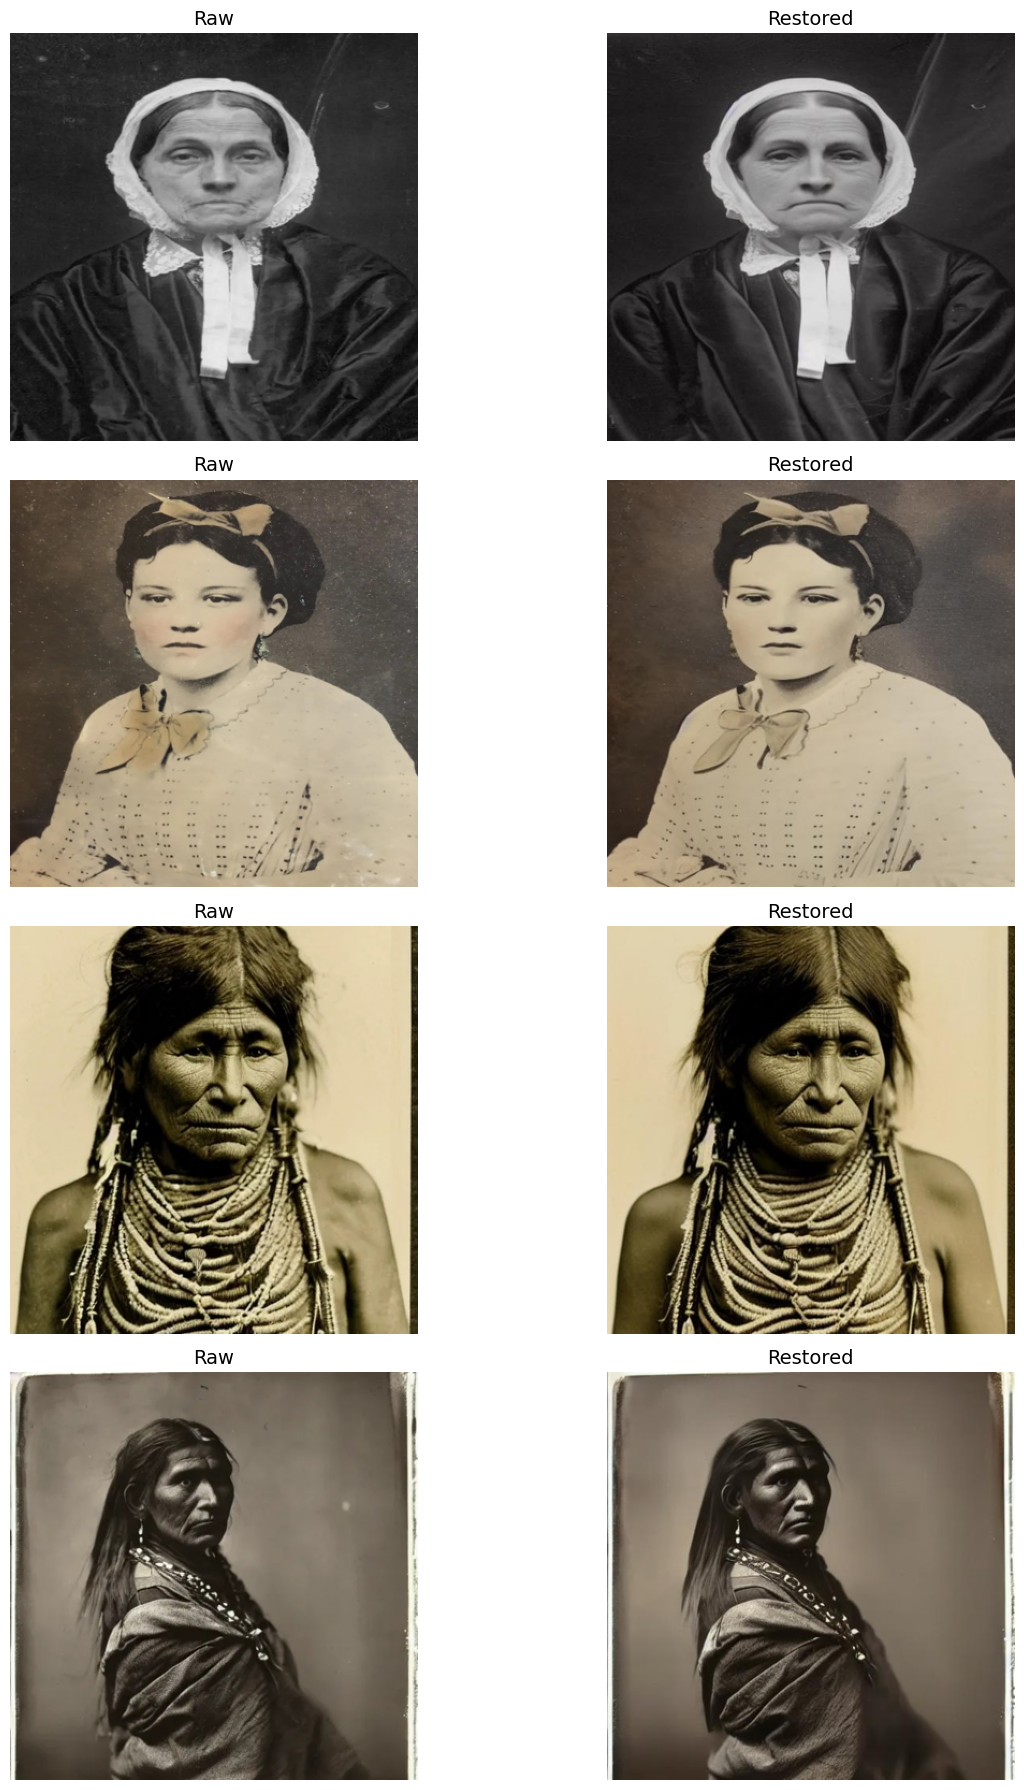

In [85]:
from PIL import Image
import matplotlib.pyplot as plt
import os

RAW = "/content/data/photos/raw"
REST = "/content/results_stage2/photos"

samples = sorted(os.listdir(RAW))[:4]  # choose first 4 images

plt.figure(figsize=(14, 18))

for i, fname in enumerate(samples):
    raw_img = Image.open(os.path.join(RAW, fname)).resize((380, 380))
    rest_img = Image.open(os.path.join(REST, fname)).resize((380, 380))

    # Raw image (left)
    plt.subplot(len(samples), 2, 2*i + 1)
    plt.imshow(raw_img)
    plt.title("Raw", fontsize=14)
    plt.axis('off')

    # Restored image (right)
    plt.subplot(len(samples), 2, 2*i + 2)
    plt.imshow(rest_img)
    plt.title("Restored", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


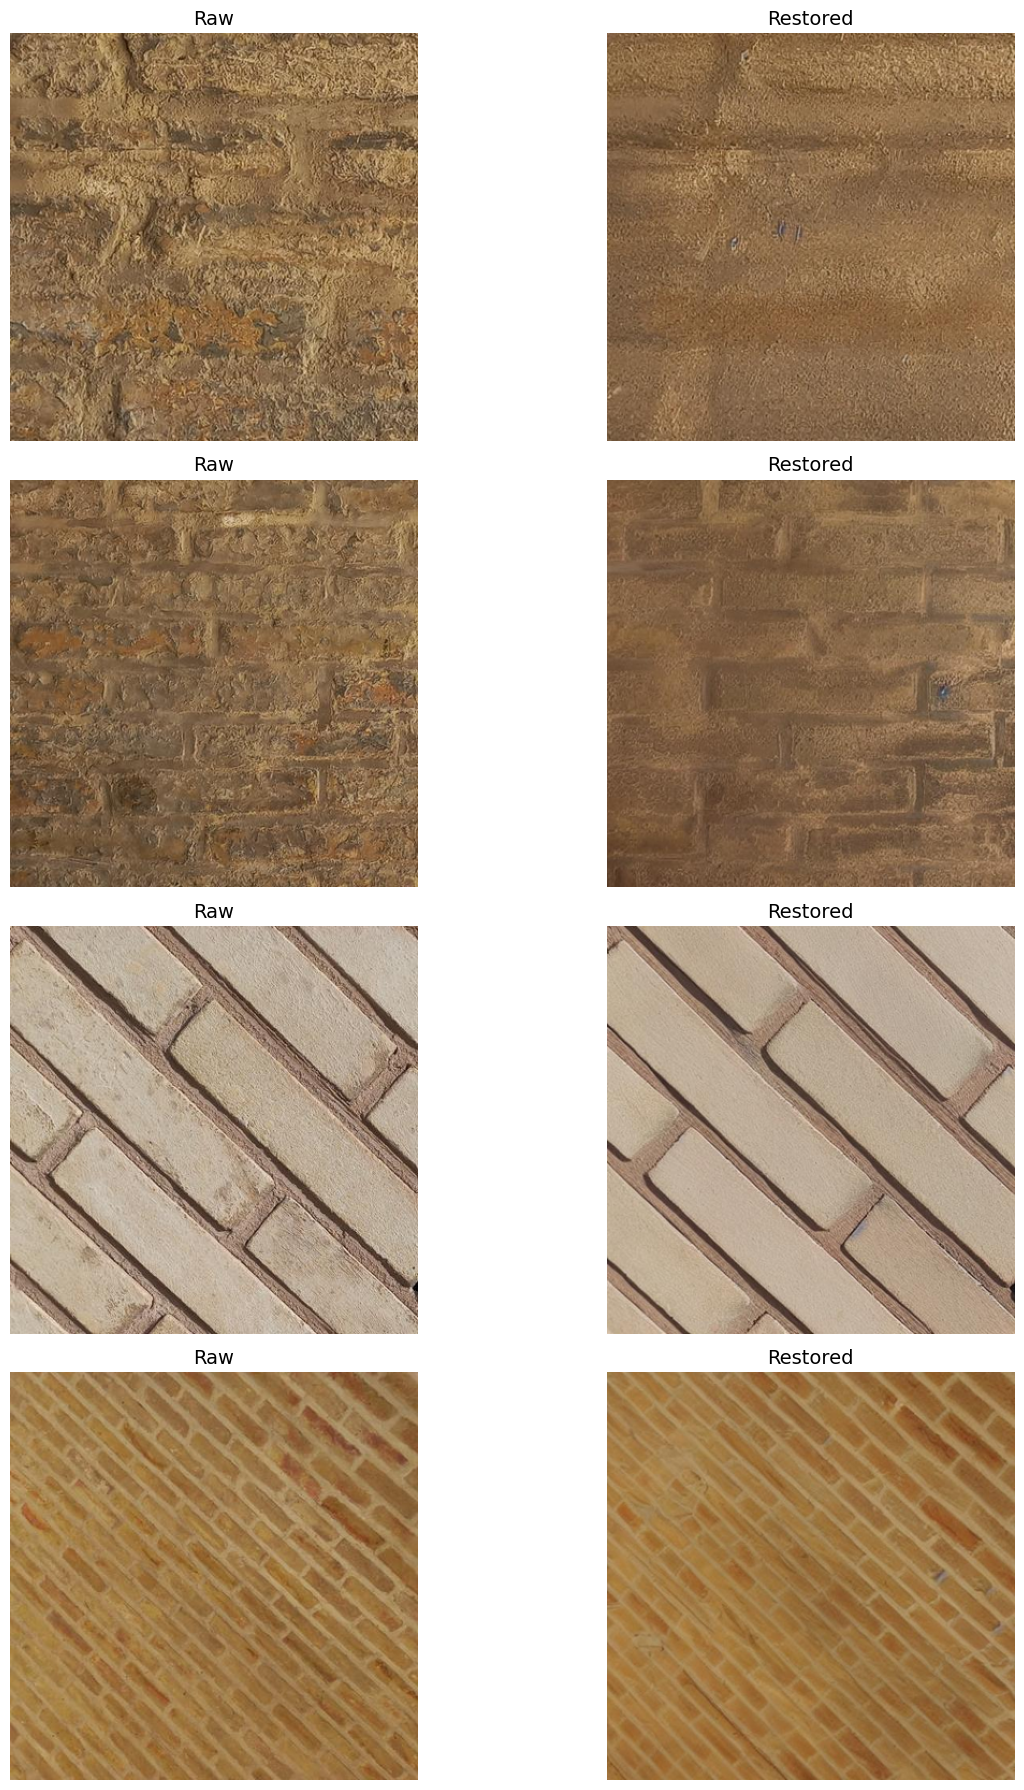

In [86]:
from PIL import Image
import matplotlib.pyplot as plt
import os

RAW = "/content/data/buildings/raw_small"          # your selected 25 raw buildings
REST = "/content/results_stage2/buildings"         # restored output

samples = sorted(os.listdir(RAW))[:4]  # choose first 4 or change number

plt.figure(figsize=(14, 18))

for i, fname in enumerate(samples):
    raw_img = Image.open(os.path.join(RAW, fname)).resize((380, 380))
    rest_img = Image.open(os.path.join(REST, fname)).resize((380, 380))

    plt.subplot(len(samples), 2, 2*i + 1)
    plt.imshow(raw_img)
    plt.title("Raw", fontsize=14)
    plt.axis('off')

    plt.subplot(len(samples), 2, 2*i + 2)
    plt.imshow(rest_img)
    plt.title("Restored", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Real-Time Restoration

In [94]:
!pip install gradio


In [ ]:
import gradio as gr
import cv2
import numpy as np
from PIL import Image

def generate_edges(img):
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return Image.fromarray(edges).convert("RGB")


def restore_img(img, prompt, negative, strength, guidance, steps):
    if img is None:
        return None, None

    img512 = img.convert("RGB").resize((512, 512))
    edges = generate_edges(img512)

    result = pipe(
        prompt=prompt,
        negative_prompt=negative,
        image=img512,
        control_image=edges,
        strength=strength,
        guidance_scale=guidance,
        num_inference_steps=steps
    ).images[0]

    return img512, result

def photo_mode(img, strength, steps):
    prompt = "old photo restoration, clean realistic skin, fix damage, restore clarity"
    negative = "distortion, artifacts, warped texture"

    return restore_img(img, prompt, negative, strength, 7.0, steps)

def building_mode(img, strength, steps):
    prompt = "heritage building restoration, sharp edges, clean texture, structural realism"
    negative = "warped lines, melted architecture, distortion"

    return restore_img(img, prompt, negative, strength, 6.5, steps)


with gr.Blocks(title="Heritage Restoration AI") as demo:

    gr.Markdown("""
    # 🏛️ Heritage Restoration AI
    Upload an image to restore it using **Diffusion + ControlNet**
    **Two modes available:**
    - 📸 Photo Restoration
    - 🏛️ Building Restoration
    """)

    with gr.Tabs():

        with gr.Tab("📸 Photo Restoration"):
            inp = gr.Image(type="pil", label="Upload Old Photo")

            strength = gr.Slider(0.1, 1.0, value=0.35, label="Restoration Strength")
            steps = gr.Slider(10, 40, value=20, step=1, label="Diffusion Steps")

            with gr.Row():
                out_raw = gr.Image(label="Original (512x512)")
                out_rest = gr.Image(label="Restored Output")

            btn = gr.Button("Restore Photo")

            btn.click(photo_mode,
                      inputs=[inp, strength, steps],
                      outputs=[out_raw, out_rest])


        with gr.Tab("🏛️ Building Restoration"):
            inp2 = gr.Image(type="pil", label="Upload Building Image")

            strength2 = gr.Slider(0.1, 1.0, value=0.35, label="Restoration Strength")
            steps2 = gr.Slider(10, 40, value=20, step=1, label="Diffusion Steps")

            with gr.Row():
                out_raw2 = gr.Image(label="Original (512x512)")
                out_rest2 = gr.Image(label="Restored Output")

            btn2 = gr.Button("Restore Building")

            btn2.click(building_mode,
                       inputs=[inp2, strength2, steps2],
                       outputs=[out_raw2, out_rest2])

demo.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://cf29e5688c568c5283.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Image Quality Metrics

In [ ]:
!pip install piq

from piq import niqe, brisque
from PIL import Image
import torch

def calculate_metrics(img_path):
    img = Image.open(img_path).convert("RGB")
    img = torch.tensor(np.array(img)).permute(2,0,1).unsqueeze(0) / 255.0

    niqe_score = niqe(img)
    brisque_score = brisque(img)

    return float(niqe_score), float(brisque_score)
